# Close Neighbors $d_\mathcal{X}$-privacy frequencies


This notebook applies $d_x$-privacy to random words from the vocabulary and identifies the rank (i.e., the "k" in k-th neighbor) of the word which was chosen as the replacement by the mechanism.

In [2]:
import pickle
from os.path import join
import numpy as np
from collections import Counter
from pathlib import Path
import sys

# Add the main directory to sys.path to be able to import config
sys.path.append(str(Path.cwd().parent))
from config import ROOT_DIR
from utils.dx import sample_noise_vectors, noisy_embeddings_to_ids
from utils.tools import rank_neighbors

# PARAMS
number_of_words = 5000
# END PARAMS

distance_metric = "euclidean"
fasttext_data_folderpath = ROOT_DIR

Load Fasttext

In [3]:
with open(join(fasttext_data_folderpath, "wiki.en.pkl"), "rb") as f:
    fasttext = pickle.load(f)

vocab_embs = np.array(list(fasttext.values()))
vocab_size = vocab_embs.shape[0]
hidden_size = vocab_embs.shape[1]
del fasttext  # Save RAM

CPU times: user 1min 37s, sys: 56.9 s, total: 2min 34s
Wall time: 3min 1s


Select *number_of_words* random words and rank their neighbors according to their distance with the word in the embedding space.

In [4]:
words_ids = np.random.randint(0, vocab_size, size=number_of_words)
words_embs = vocab_embs[words_ids]

words_neighbors_ranked = rank_neighbors(words_embs, vocab_embs, distance_metric)

CPU times: user 44.6 s, sys: 9min 49s, total: 10min 34s
Wall time: 10min 39s


Add noise to the embeddings of the words following the $d_x$-privacy mechanism and count which neighbor was chosen, represented by its rank in the neighbor list of the initial word.

In [5]:
epsilons = [i for i in range(1, 51)]
neighbor_counted_occurences = {}

for epsilon in epsilons:
    embeddings = np.copy(words_embs)
    noise = sample_noise_vectors(
        dimension=hidden_size, shape1=1, shape2=number_of_words, epsilon=epsilon
    )[0]
    # Adding noise to embeddings
    noisy_embedding = embeddings + noise

    # Convert embedding back to text via Nearest neighbor Search
    noisy_word_ids = noisy_embeddings_to_ids(
        noisy_embedding, vocab_embs, distance_metric
    )

    # for all words_ids, get the rank k of noisy_word_ids[i] and increase a counter at index k
    noisy_word_ids_ranks = words_neighbors_ranked[
        np.arange(number_of_words), noisy_word_ids
    ]  # This line, for all the elements i in the first dimension of words_neighbors_ranked, gets the particular value pointed by the index which is stored at noisy_word_ids[i]
    noisy_word_ids_ranks_counted = Counter(noisy_word_ids_ranks)
    neighbor_counted_occurences[epsilon] = [
        noisy_word_ids_ranks_counted[k] for k in range(vocab_size)
    ]

CPU times: user 8min 8s, sys: 3.54 s, total: 8min 12s
Wall time: 1min 54s


Results are stored in *neighbor_counted_occurences*, which is a dictionary where the keys are integers representing the value of epsilon. The dictionary associates each epsilon with a list, where list[i] contains the number of times the i-th neighbor was chosen as the replacement of a word. 

Plot Figure

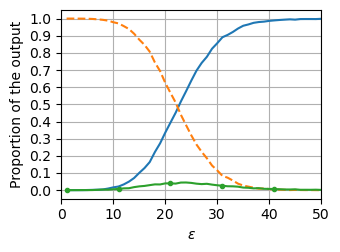

In [6]:
import matplotlib.pyplot as plt
close_neighbors_max_rank = 100 # The maximum rank (including) of what is considered a "close" neighbor 

initial_word_frequency = np.array([neighbor_counted_occurences[i][0] for i in epsilons])
close_neighbors_frequency = np.array([sum(neighbor_counted_occurences[i][1:close_neighbors_max_rank+1]) for i in epsilons])
distant_neighbors_frequency = np.array([sum(neighbor_counted_occurences[i][close_neighbors_max_rank+1:]) for i in epsilons])

fig, ax = plt.subplots(figsize=(3.5, 2.62))

ax.plot(epsilons, initial_word_frequency/number_of_words, label="Original value", linewidth=1.5, markersize=5)
ax.plot(epsilons, distant_neighbors_frequency/number_of_words, label="Distant neighbors", linewidth=1.5,linestyle='dashed')
ax.plot(epsilons, close_neighbors_frequency/number_of_words, label="Close neighbors", linewidth=1.5, marker=".", markevery=10)

ax.set_xlabel("$\epsilon$")
ax.set_ylabel("Proportion of the output")
ax.set_yticks(np.arange(0, 1.1, 0.1))

ax.set_xlim(0,50)
#ax.legend(framealpha=0.4, loc="right")
ax.grid()
fig.tight_layout()
fig.show()